# NOTEBOOK COPIA EJEMPLO NIXTLA hierarchicalforecast

----
### ejemplo conciliacion TEMPORAL de los datos
- Ejecución de notebook ejemplo base de nixtla - replicar código ejemplo y análisis extra para entender código y modelos ya hechos

- EJEMPLO LA DATA FULL DE TOURISM

- FUENTES:
    - geographical aggregation (POINT CONCILIATION): https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/australiandomestictourism.html

    - temporal aggregation (TEMPORAL CONCILIATION): https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/australiandomestictourismtemporal.html
 
    - geographical and temporal aggregation: https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/australiandomestictourismcrosstemporal.html
 
    - paper base investigación (los códigos de nixtla replican lo obtenido por el paper): https://robjhyndman.com/seminars/fr_overview.html

# TEMPORAL RECONCILIATION: Temporal Aggregation (Tourism)
FUENTE BASE: https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/australiandomestictourismtemporal.html

### 0. Install nixtla package

In [1]:
# pip install hierarchicalforecast
# pip install datasetsforecast
# pip install statsforecast

In [2]:
import hierarchicalforecast
from datasetsforecast.hierarchical import HierarchicalData
import pandas as pd

## run code - example nixtla

In [3]:
import numpy as np
import pandas as pd

### 1. Read data - download data example hyndman

#### 1.1 read raw data

In [4]:
data_raw = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
data_raw = data_raw.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
data_raw.insert(0, 'Country', 'Australia')
data_raw = data_raw[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
data_raw['ds'] = data_raw['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
data_raw['ds'] = pd.PeriodIndex(data_raw["ds"], freq='Q').to_timestamp()

In [5]:
# print data - se observa que a diferencia del ejemplo small que se carga la matriz S para realizar la reconciliación de forecast
# aquí estan todas las series y hay que armar la matriz de cómo se relacionan los forecasts
data_raw.head()

,Country,Region,State,Purpose,ds,y
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687
3,Australia,Adelaide,South Australia,Business,1998-10-01,127.160464
4,Australia,Adelaide,South Australia,Business,1999-01-01,137.448533


In [6]:
# OBS: NOTAR QUE EN ESTE EJEMPLO NO SE GENERAN LAS SERIES A NIVEL TOTAL COUNTRY POR EJEMPLO
# sino que se toman las series (que en este caso corresponde al mayor nivel de desagregación) y se trabaja en la conciliación temporal

### 2. Generar unique_id (una única columna identificador de las series con las que se trabaja)

In [7]:
Y_df = data_raw.copy()
Y_df["unique_id"] = Y_df["Country"] + "/" + Y_df["State"] + "/" + Y_df["Region"] + "/" + Y_df["Purpose"]

In [8]:
Y_df.head(3)

,Country,Region,State,Purpose,ds,y,unique_id
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690,Australia/South Australia/Adelaide/Business
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316,Australia/South Australia/Adelaide/Business
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687,Australia/South Australia/Adelaide/Business


### 3. Discovery data

In [9]:
# en el notebook 0_b se realiza un mayor discovery de los datos para entender su distribución

### 4. Split Train/Test sets
We use the final two years (8 quarters) as test set. Consequently, our forecast horizon=8.

In [10]:
# param - horizonte a forecastear
horizon = 8

In [11]:
Y_test_df = Y_df.groupby("unique_id", as_index=False).tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

In [12]:
# print informativo tamaño de la data original, data_train y data_test
print('Y_df: ', Y_df.shape)
print('Y_train_df: ', Y_train_df.shape)
print('Y_test_df: ', Y_test_df.shape)

Y_df:  (24320, 7)
Y_train_df:  (21888, 7)
Y_test_df:  (2432, 7)


### 5. Aggregating the dataset according to temporal hierarchy

In [13]:
from hierarchicalforecast.utils import aggregate_temporal

In [14]:
# de forma similar a la agregacion point value (geográfica del notebook anterior)

# definir un diccionario con la agregacion temporal de los datos
spec_temporal = {"year": 4, "semiannual": 2, "quarter": 1}

In [15]:
# print data (se puede observar que la data es trimestral, así agregar 4 datos ya representa una agregación ANUAL)
Y_df.head(3)

,Country,Region,State,Purpose,ds,y,unique_id
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690,Australia/South Australia/Adelaide/Business
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316,Australia/South Australia/Adelaide/Business
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687,Australia/South Australia/Adelaide/Business


In [16]:
# print data (se puede observar que la data es trimestral, así agregar 4 datos ya representa una agregación ANUAL) 
# (tal como está definido en el diccionario para la agregación temporal)
Y_df.head(3)

,Country,Region,State,Purpose,ds,y,unique_id
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690,Australia/South Australia/Adelaide/Business
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316,Australia/South Australia/Adelaide/Business
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687,Australia/South Australia/Adelaide/Business


In [17]:
# realizar agregación temporal en train y train
Y_train_df, S_train_df, tags_train = aggregate_temporal(df = Y_train_df, spec=spec_temporal)
Y_test_df, S_test_df, tags_test = aggregate_temporal(df = Y_test_df, spec = spec_temporal)

In [18]:
# print tamaño data
print('Y_train_df: ', Y_train_df.shape)
print('Y_test_df: ', Y_test_df.shape)

Y_train_df:  (38304, 4)
Y_test_df:  (4256, 4)


In [19]:
# print data 
# - SE PUEDE OBSERVAR QUE SE GENERA UNA COLUMNA CON EL TEMPORAL ID. LA AGREGACIÓN TEMPORAL
# - Y CON LA CREACIÓN DE LA COLUMNA TEMPORAL_ID TAMBIÉN SE CREARON LAS SERIES AGREGADAS ANUALMENTE, SEMESTRAL Y TRIMESTRAL (la base)
Y_train_df.head()

,temporal_id,unique_id,ds,y
0,year-1,Australia/ACT/Canberra/Business,1998-10-01,481.394885
1,year-2,Australia/ACT/Canberra/Business,1999-10-01,592.395157
2,year-3,Australia/ACT/Canberra/Business,2000-10-01,613.692622
3,year-4,Australia/ACT/Canberra/Business,2001-10-01,519.632984
4,year-5,Australia/ACT/Canberra/Business,2002-10-01,625.864384


In [20]:
# print agregaciones temporales únicas generadas
Y_train_df['temporal_id'].unique()

array(['year-1', 'year-2', 'year-3', 'year-4', 'year-5', 'year-6',
       'year-7', 'year-8', 'year-9', 'year-10', 'year-11', 'year-12',
       'year-13', 'year-14', 'year-15', 'year-16', 'year-17', 'year-18',
       'semiannual-1', 'semiannual-2', 'semiannual-3', 'semiannual-4',
       'semiannual-5', 'semiannual-6', 'semiannual-7', 'semiannual-8',
       'semiannual-9', 'semiannual-10', 'semiannual-11', 'semiannual-12',
       'semiannual-13', 'semiannual-14', 'semiannual-15', 'semiannual-16',
       'semiannual-17', 'semiannual-18', 'semiannual-19', 'semiannual-20',
       'semiannual-21', 'semiannual-22', 'semiannual-23', 'semiannual-24',
       'semiannual-25', 'semiannual-26', 'semiannual-27', 'semiannual-28',
       'semiannual-29', 'semiannual-30', 'semiannual-31', 'semiannual-32',
       'semiannual-33', 'semiannual-34', 'semiannual-35', 'semiannual-36',
       'quarter-1', 'quarter-2', 'quarter-3', 'quarter-4', 'quarter-5',
       'quarter-6', 'quarter-7', 'quarter-8', 'quart

In [21]:
# print de un ejemplo data agregacion temporal anual que está para cada una de las unique_id
Y_train_df[Y_train_df['temporal_id'] == 'year-1']

,temporal_id,unique_id,ds,y
0,year-1,Australia/ACT/Canberra/Business,1998-10-01,481.394885
18,year-1,Australia/ACT/Canberra/Holiday,1998-10-01,604.140999
36,year-1,Australia/ACT/Canberra/Other,1998-10-01,94.557381
54,year-1,Australia/ACT/Canberra/Visiting,1998-10-01,672.761735
72,year-1,Australia/New South Wales/Blue Mountains/Business,1998-10-01,59.195531
...,...,...,...,...
5382,year-1,Australia/Western Australia/Australia's South ...,1998-10-01,481.534449
5400,year-1,Australia/Western Australia/Experience Perth/B...,1998-10-01,623.848487
5418,year-1,Australia/Western Australia/Experience Perth/H...,1998-10-01,1114.624229
5436,year-1,Australia/Western Australia/Experience Perth/O...,1998-10-01,187.191282


In [22]:
Y_train_df['unique_id'].unique().shape # cantidad de series única

(304,)

In [23]:
# print matriz S generada (agregaciónm temporal)
S_train_df

,temporal_id,quarter-1,quarter-2,quarter-3,quarter-4,quarter-5,quarter-6,quarter-7,quarter-8,quarter-9,...,quarter-63,quarter-64,quarter-65,quarter-66,quarter-67,quarter-68,quarter-69,quarter-70,quarter-71,quarter-72
0,year-1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,year-2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,year-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,year-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,year-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,quarter-68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
122,quarter-69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
123,quarter-70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
124,quarter-71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# se ve cómo se relacionan las series individuales base (quater-x) con los diferentes niveles de agregación
# ej año-1 se compone de las series quater-1, quater-2, quater-3, quater-4
# ej año-2 se compone de las series quater-5, quater-6, quater-7, quater-8

S_train_df.iloc[:5, :10]

,temporal_id,quarter-1,quarter-2,quarter-3,quarter-4,quarter-5,quarter-6,quarter-7,quarter-8,quarter-9
0,year-1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,year-2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2,year-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,year-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,year-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# print diccionario tags
tags_train.keys()

dict_keys(['year', 'semiannual', 'quarter'])

In [26]:
tags_train['year']

array(['year-1', 'year-2', 'year-3', 'year-4', 'year-5', 'year-6',
       'year-7', 'year-8', 'year-9', 'year-10', 'year-11', 'year-12',
       'year-13', 'year-14', 'year-15', 'year-16', 'year-17', 'year-18'],
      dtype=object)

In [27]:
tags_train['semiannual']

array(['semiannual-1', 'semiannual-2', 'semiannual-3', 'semiannual-4',
       'semiannual-5', 'semiannual-6', 'semiannual-7', 'semiannual-8',
       'semiannual-9', 'semiannual-10', 'semiannual-11', 'semiannual-12',
       'semiannual-13', 'semiannual-14', 'semiannual-15', 'semiannual-16',
       'semiannual-17', 'semiannual-18', 'semiannual-19', 'semiannual-20',
       'semiannual-21', 'semiannual-22', 'semiannual-23', 'semiannual-24',
       'semiannual-25', 'semiannual-26', 'semiannual-27', 'semiannual-28',
       'semiannual-29', 'semiannual-30', 'semiannual-31', 'semiannual-32',
       'semiannual-33', 'semiannual-34', 'semiannual-35', 'semiannual-36'],
      dtype=object)

### 5B. OJO. 
#### SI SE USA EN PRODUCTIVO NO VA A EXISTIR UN DATAFRAME TEST YA QUE AÚN NO SE CONOCEN LOS DATOS
#### SIN EMBARGO, SE NECESITA CREAR UN DATAFRAME FUTURE
If you don’t have a test set available, as is usually the case when you’re making forecasts, it is necessary to create a future dataframe that holds the correct bottom-level unique_ids and timestamps so that they can be temporally aggregated. We can use the make_future_dataframe helper function for that.

In [28]:
from hierarchicalforecast.utils import make_future_dataframe

In [29]:
# crear dataframe future (ej ejecuciones en productivo donde no existen la data true)
Y_test_df_new = make_future_dataframe(Y_train_df, freq = "QS", h = horizon)

In [30]:
Y_test_df_new

,unique_id,ds
0,Australia/ACT/Canberra/Business,2016-01-01
1,Australia/ACT/Canberra/Business,2016-04-01
2,Australia/ACT/Canberra/Business,2016-07-01
3,Australia/ACT/Canberra/Business,2016-10-01
4,Australia/ACT/Canberra/Business,2017-01-01
...,...,...
2427,Australia/Western Australia/Experience Perth/V...,2016-10-01
2428,Australia/Western Australia/Experience Perth/V...,2017-01-01
2429,Australia/Western Australia/Experience Perth/V...,2017-04-01
2430,Australia/Western Australia/Experience Perth/V...,2017-07-01


In [31]:
# Y_test_df_new can be then used in aggregate_temporal to construct the temporally aggregated structures

# llamar la función de nixtla para crear el dataframe con la agregación temporal
# están las series unique_id para cada quater y se crea la agregación temporal para tener las series por año, semestre y quater
Y_test_df_new, S_test_df_new, tags_test_new = aggregate_temporal(df = Y_test_df_new,  spec = spec_temporal)

In [32]:
Y_test_df_new

,temporal_id,unique_id,ds
0,year-1,Australia/ACT/Canberra/Business,2016-10-01
1,year-2,Australia/ACT/Canberra/Business,2017-10-01
2,year-1,Australia/ACT/Canberra/Holiday,2016-10-01
3,year-2,Australia/ACT/Canberra/Holiday,2017-10-01
4,year-1,Australia/ACT/Canberra/Other,2016-10-01
...,...,...,...
4251,quarter-4,Australia/Western Australia/Experience Perth/V...,2016-10-01
4252,quarter-5,Australia/Western Australia/Experience Perth/V...,2017-01-01
4253,quarter-6,Australia/Western Australia/Experience Perth/V...,2017-04-01
4254,quarter-7,Australia/Western Australia/Experience Perth/V...,2017-07-01


In [33]:
# ----> OJO
# OJO: AL FINAL SE OBTIENE EL MISMO FORMATO DE DATAFRAME ÚNICAMENTE QUE EN EL "Y_test_df" tiene el valor real representando 
# un entrenamiento de modelos y su evaluación. Mientras que "Y_test_df_new" NO TIENE EL REAL representando la implementación+
# del forecast en un ambiente productivo

In [34]:
# ----> OJO 2
# A diferencia de la conciliación POINT VALUE (ej agregación geográfica de los datos) en la AGREGACION TEMPORAL
# se CREA UNA COLUMNA ADICIONAL "TEMPORAL_ID" como key de la agregación temporal, MIENTRAS QUE "UNIQUE_ID" contiene
# únicamente el id de las series originales

# DIFERENTE A LA A AGREGACIÓN POINT VALUE DONDE LAS NUEVAS SERIES CREADAS TENÍAN UN ID QUE SE MANTIENE EN LA COLUMNA "UNIQUE_ID"

In [35]:
# mientras que se puede valir que la matriz S y el diccionario tags es exactamente el mismo entre "Y_test_df" y "Y_test_df_new"

In [36]:
S_test_df_new

,temporal_id,quarter-1,quarter-2,quarter-3,quarter-4,quarter-5,quarter-6,quarter-7,quarter-8
0,year-1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,year-2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,semiannual-1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,semiannual-2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,semiannual-3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,semiannual-4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,quarter-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,quarter-2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,quarter-3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,quarter-4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [37]:
S_test_df

,temporal_id,quarter-1,quarter-2,quarter-3,quarter-4,quarter-5,quarter-6,quarter-7,quarter-8
0,year-1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,year-2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,semiannual-1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,semiannual-2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,semiannual-3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,semiannual-4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,quarter-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,quarter-2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,quarter-3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,quarter-4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 6. Computing base forecasts!!
Realizar forecast para los diferentes horizontes temporales

**Note also that both frequency and horizon are different for each temporal aggregation. In this example, the lowest level has a quarterly frequency, and a horizon of 8 (constituting 2 years). The year aggregation thus has a yearly frequency with a horizon of 2.**

In [38]:
from statsforecast.models import AutoETS
from statsforecast.core import StatsForecast

In [39]:
Y_hat_dfs = []
id_cols = ["unique_id", "temporal_id", "ds", "y"]
# We will train a model for each temporal level
for level, temporal_ids_train in tags_train.items():
    # Filter the data for the level
    Y_level_train = Y_train_df.query("temporal_id in @temporal_ids_train")
    temporal_ids_test = tags_test[level]
    Y_level_test = Y_test_df.query("temporal_id in @temporal_ids_test")
    # For each temporal level we have a different frequency and forecast horizon
    freq_level = pd.infer_freq(Y_level_train["ds"].unique())
    horizon_level = Y_level_test["ds"].nunique()
    # Train a model and create forecasts
    fcst = StatsForecast(models=[AutoETS(model='ZZZ')], freq=freq_level, n_jobs=-1)
    Y_hat_df_level = fcst.forecast(df=Y_level_train[["ds", "unique_id", "y"]], h=horizon_level, level=[80, 90])
    # Add the test set to the forecast
    Y_hat_df_level = Y_hat_df_level.merge(Y_level_test, on=["ds", "unique_id"], how="left")
    # Put cols in the right order (for readability)
    Y_hat_cols = id_cols + [col for col in Y_hat_df_level.columns if col not in id_cols]
    Y_hat_df_level = Y_hat_df_level[Y_hat_cols]
    # Append the forecast to the list
    Y_hat_dfs.append(Y_hat_df_level)

Y_hat_df = pd.concat(Y_hat_dfs, ignore_index=True)

In [40]:
# print forecast generados
# OJO EL NOTEBOOK BASE ejemplo nixtla ESTÁ PENSADO PARA CONCILIAR TANTO FORECAST ESTOCÁSTICOS COMO FORECAST PROBABILISTICO (fcst intervalos)
Y_hat_df.head()

,unique_id,temporal_id,ds,y,AutoETS,AutoETS-lo-90,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-90
0,Australia/ACT/Canberra/Business,year-1,2016-10-01,754.139245,616.497987,474.588329,505.932195,727.063780,758.407646
1,Australia/ACT/Canberra/Business,year-2,2017-10-01,809.950839,616.497987,472.025333,503.935293,729.060681,760.970641
2,Australia/ACT/Canberra/Holiday,year-1,2016-10-01,735.365896,584.301181,427.683064,462.275616,706.326746,740.919299
3,Australia/ACT/Canberra/Holiday,year-2,2017-10-01,834.717900,584.301181,427.683063,462.275615,706.326747,740.919299
4,Australia/ACT/Canberra/Other,year-1,2016-10-01,175.239916,112.787569,65.076862,75.614820,149.960319,160.498277


### 7. Validar que los forecast con diferente agregación temporal da distinto

In [41]:
# generar filtros para mostrar resultados de forecast de una serie puntual

# unique_id de ejemplo
unique_id_example = 'Australia/ACT/Canberra/Business'

# temporal id de ejemplo (quiero tomar el año 1 y sé que está conformado por quater1, quater2, quater3, quater4)
list_temporal_id_example_year = 'year-1'
list_temporal_id_example_quarter = ['quarter-1', 'quarter-2', 'quarter-3', 'quarter-4']

In [42]:
# mostrar fcst serie de ejemplo - FCST ANUAL
mask_example_temporal_year = (Y_hat_df['unique_id'] == unique_id_example) & (Y_hat_df['temporal_id'] == list_temporal_id_example_year)
Y_hat_df[mask_example_temporal_year]

,unique_id,temporal_id,ds,y,AutoETS,AutoETS-lo-90,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-90
0,Australia/ACT/Canberra/Business,year-1,2016-10-01,754.139245,616.497987,474.588329,505.932195,727.06378,758.407646


In [43]:
# mostrar fcst serie de ejemplo - QUATER
mask_example_temporal_quater = (Y_hat_df['unique_id'] == unique_id_example) & (Y_hat_df['temporal_id'].isin(list_temporal_id_example_quarter))
Y_hat_df[mask_example_temporal_quater]

,unique_id,temporal_id,ds,y,AutoETS,AutoETS-lo-90,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-90
1824,Australia/ACT/Canberra/Business,quarter-1,2016-01-01,152.599480,144.692239,81.129334,95.168598,194.215880,208.255145
1825,Australia/ACT/Canberra/Business,quarter-2,2016-04-01,195.719394,144.692239,81.129334,95.168598,194.215881,208.255145
1826,Australia/ACT/Canberra/Business,quarter-3,2016-07-01,219.421298,144.692239,81.129333,95.168597,194.215881,208.255145
1827,Australia/ACT/Canberra/Business,quarter-4,2016-10-01,186.399072,144.692239,81.129333,95.168597,194.215881,208.255146


In [44]:
# sumar fcst serie de ejemplo - QUARTER - VALIDAR QUE SUMAR FCST INDIVIDUAL QUATER NO COINCIDE VOLUMEN CON FCST ANUAL
columns_to_sum = ['y', 'AutoETS', 'AutoETS-lo-90', 'AutoETS-lo-80', 'AutoETS-hi-80', 'AutoETS-hi-90']
Y_hat_df[mask_example_temporal_quater][columns_to_sum].sum(axis = 0).to_frame().T

,y,AutoETS,AutoETS-lo-90,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-90
0,754.139245,578.768957,324.517333,380.67439,776.863523,833.020581


In [45]:
# OBS: se puede ver que al sumar el fcst se obtiene que el real se mantiene pero el FCST no se mantiene
# (lo esperado ya que forecastear un año da resultados distintos que forecastear cada trimestre y luego consolidar)

### 8. Reconcile forecasts !!!
We can use the HierarchicalReconciliation class to reconcile the forecasts. In this example we use BottomUp and MinTrace. Note that we have to set temporal=True in the reconcile function.

Note that temporal reconcilation currently isn’t supported for insample reconciliation methods, such as MinTrace(method='mint_shrink').

In [46]:
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

In [47]:
# generar listado con reconciliadores a utilizar
reconcilers = [
    BottomUp(),
    MinTrace(method="ols"),
]

In [48]:
# instancia de la clase con los metodos para reconciliar fcst
hrec = HierarchicalReconciliation(reconcilers = reconcilers)
hrec

In [49]:
# print parámetros que se necesitan para RECONCILIACIÓN TEMPORAL
Y_hat_df.head(3)

,unique_id,temporal_id,ds,y,AutoETS,AutoETS-lo-90,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-90
0,Australia/ACT/Canberra/Business,year-1,2016-10-01,754.139245,616.497987,474.588329,505.932195,727.063780,758.407646
1,Australia/ACT/Canberra/Business,year-2,2017-10-01,809.950839,616.497987,472.025333,503.935293,729.060681,760.970641
2,Australia/ACT/Canberra/Holiday,year-1,2016-10-01,735.365896,584.301181,427.683064,462.275616,706.326746,740.919299


In [50]:
S_test_df.head(3)

,temporal_id,quarter-1,quarter-2,quarter-3,quarter-4,quarter-5,quarter-6,quarter-7,quarter-8
0,year-1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,year-2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,semiannual-1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
tags_test

{'year': array(['year-1', 'year-2'], dtype=object),
 'semiannual': array(['semiannual-1', 'semiannual-2', 'semiannual-3', 'semiannual-4'],
       dtype=object),
 'quarter': array(['quarter-1', 'quarter-2', 'quarter-3', 'quarter-4', 'quarter-5',
        'quarter-6', 'quarter-7', 'quarter-8'], dtype=object)}

In [52]:
# ------> OBSERVACIÓN IMPORTANTE!!
# para la reconciliación "mint_shrink" se necesita pasar los datos Y_df = Y_fitted_df (datos de train con real y predicho)
# pero para las otras reconciliaciones solo se necesita pasar los forecast generados (NO SE NECESITA TRAIN)

# como "mint_shrink" no es soportado para conciliación temporal. NO SE NECESITAN LOS DATOS DE TRAIN real y predicted

In [53]:
# generar reconciliación
Y_rec_df = hrec.reconcile(Y_hat_df = Y_hat_df, 
                          S = S_test_df, 
                          tags = tags_test, 
                          temporal = True, # conciliacion temporal
                          level = [80, 90] # conciliacion probabilística
                         )

In [54]:
Y_rec_df.head()

,unique_id,temporal_id,ds,y,AutoETS,AutoETS-lo-90,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-90,AutoETS/BottomUp,AutoETS/BottomUp-lo-90,AutoETS/BottomUp-lo-80,AutoETS/BottomUp-hi-80,AutoETS/BottomUp-hi-90,AutoETS/MinTrace_method-ols,AutoETS/MinTrace_method-ols-lo-90,AutoETS/MinTrace_method-ols-lo-80,AutoETS/MinTrace_method-ols-hi-80,AutoETS/MinTrace_method-ols-hi-90
0,Australia/ACT/Canberra/Business,year-1,2016-10-01,754.139245,616.497987,474.588329,505.932195,727.063780,758.407646,578.768957,451.643145,479.721674,677.816240,705.894769,600.319593,508.776066,528.995465,671.643721,691.863120
1,Australia/ACT/Canberra/Holiday,year-1,2016-10-01,735.365896,584.301181,427.683064,462.275616,706.326746,740.919299,584.386505,454.162576,482.925392,685.847619,714.610435,584.365744,483.758101,505.979509,662.751978,684.973386
2,Australia/ACT/Canberra/Other,year-1,2016-10-01,175.239916,112.787569,65.076862,75.614820,149.960319,160.498277,112.817793,73.130681,81.896452,143.739133,152.504904,112.800181,82.258359,89.004191,136.596170,143.342003
3,Australia/ACT/Canberra/Visiting,year-1,2016-10-01,792.656310,713.703947,608.486824,631.726337,795.681557,818.921071,713.699358,616.368083,637.865833,789.532882,811.030632,713.639752,644.921832,660.099694,767.179810,782.357673
4,Australia/New South Wales/Blue Mountains/Business,year-1,2016-10-01,73.981175,78.095125,32.930588,42.906168,113.284082,123.259662,78.068305,38.085984,46.916958,109.219652,118.050626,78.059892,49.216973,55.587565,100.532219,106.902812


### 9. Validar resulados conciliación (se va a hacer el enfoque en el forecast NO probabilístico - forecastear un punto)

In [55]:
# generar filtros para mostrar resultados de forecast de una serie puntual

# unique_id de ejemplo
unique_id_example = 'Australia/ACT/Canberra/Business'

# temporal id de ejemplo (quiero tomar el año 1 y sé que está conformado por quater1, quater2, quater3, quater4)
list_temporal_id_example_year = 'year-1'
list_temporal_id_example_quarter = ['quarter-1', 'quarter-2', 'quarter-3', 'quarter-4']

# mostrar solo los forecast NO probabilistico y sus conciliaciones
list_fixed_columns = ['unique_id', 'temporal_id', 'ds']
list_fcsts = ['AutoETS', 'AutoETS/BottomUp', 'AutoETS/MinTrace_method-ols']

In [56]:
# mostrar fcst serie de ejemplo - FCST ANUAL
mask_example_temporal_year = (Y_rec_df['unique_id'] == unique_id_example) & (Y_rec_df['temporal_id'] == list_temporal_id_example_year)
Y_rec_df[mask_example_temporal_year][list_fixed_columns + list_fcsts]

,unique_id,temporal_id,ds,AutoETS,AutoETS/BottomUp,AutoETS/MinTrace_method-ols
0,Australia/ACT/Canberra/Business,year-1,2016-10-01,616.497987,578.768957,600.319593


In [57]:
# mostrar fcst serie de ejemplo - QUATER
mask_example_temporal_quater = (Y_rec_df['unique_id'] == unique_id_example) & (Y_rec_df['temporal_id'].isin(list_temporal_id_example_quarter))
Y_rec_df[mask_example_temporal_quater][list_fixed_columns + list_fcsts]

,unique_id,temporal_id,ds,AutoETS,AutoETS/BottomUp,AutoETS/MinTrace_method-ols
1824,Australia/ACT/Canberra/Business,quarter-1,2016-01-01,144.692239,144.692239,150.079898
2128,Australia/ACT/Canberra/Business,quarter-2,2016-04-01,144.692239,144.692239,150.079898
2432,Australia/ACT/Canberra/Business,quarter-3,2016-07-01,144.692239,144.692239,150.079898
2736,Australia/ACT/Canberra/Business,quarter-4,2016-10-01,144.692239,144.692239,150.079898


In [58]:
# mostrar fcst serie de ejemplo - QUATER - sumando forecast quater para tener forecast anual
Y_rec_df[mask_example_temporal_quater][list_fcsts].sum(axis = 0).to_frame().T

,AutoETS,AutoETS/BottomUp,AutoETS/MinTrace_method-ols
0,578.768957,578.768957,600.319593


In [59]:
# OBSERVACIONES
# se puede ver que el fsct por quarter sumándolos para tener fcst anual da "578.768957"
# si el fcst por quater se consolidara para un fcst anual sumándolos (lógica bottom/up) daría "578.768957" que es lo que muestra el 
# fcst anual consolidado
# si el fcst por quater se consolida con el fcst anual por MinTrace se obtiene como fcst anual "600.319593"

### 10. Evaluation

In [60]:
from hierarchicalforecast.evaluation import evaluate
from utilsforecast.losses import mae, scaled_crps

In [61]:
evaluation = evaluate(df = Y_rec_df.drop(columns = 'unique_id'),
                      tags = tags_test,
                      metrics = [mae, scaled_crps],
                      level = [80, 90],
                      id_col='temporal_id')

evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.3}'.format).astype(np.float64)

In [62]:
evaluation

,level,metric,Base,BottomUp,MinTrace(ols)
0,year,mae,47.0000,50.8000,46.7000
1,year,scaled_crps,0.0562,0.0620,0.0666
2,semiannual,mae,29.5000,30.5000,29.1000
3,semiannual,scaled_crps,0.0643,0.0681,0.0727
4,quarter,mae,19.4000,19.4000,18.7000
5,quarter,scaled_crps,0.0876,0.0876,0.0864
6,Overall,mae,26.2000,27.1000,25.7000
7,Overall,scaled_crps,0.0765,0.0784,0.0797


In [63]:
# OBSERVACIONES
# SE PUEDE VER QUE MinTrace(ols) MEJORA TODOS LOS FORECASTS vs hacer los forecast separados (que no coinciden los volumenes)
# ADEMÁS UNA LÓGICA BOTOM/UP empeora el fcst semestral y anual

MinTrace(ols) is the best overall point method, scoring the lowest mae on the year and semiannual aggregated forecasts as well as the quarter bottom-level aggregated forecasts. However, the Base method is better overall on the probabilistic measure crps, where it scores the lowest, indicating that the uncertainty levels predicted with the Base method are better in this example.

### 11. Extra - plot S matrix

In [64]:
from hierarchicalforecast.utils import HierarchicalPlot

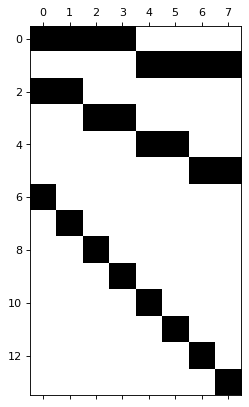

In [65]:
hplot = HierarchicalPlot(S=S_test_df, tags=tags_test, S_id_col="temporal_id")
hplot.plot_summing_matrix()